# predicting health coverage in the US

This project will call data from the American Community Survey Public Use MicroSample(PUMS) API. The most recent survey publicly availble at this API is from 2019. (Note data from 2020 are available to download in csv files).

This project uses the Census Bureau Data API but is not endorsed or certified by the Census Bureau.

1. American Community Survey (ACS) (census.gov).
https://www.census.gov/programs-surveys/acs/
2. American Community Survey Data via API (census.gov).
https://www.census.gov/programs-surveys/acs/data/data-via-api.html

The goal of this project is to predict whether an individual has health insurance (or not) based on demographic data in the PUMS. 

In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils

Load in data files saved after EDA.

In [2]:
_,_,_,nsamples=utils.getVars()
datadir  = os.path.join(os.getcwd(),"small_data")


new_df_fname = os.path.join(datadir,'allstates_subsample' + str(nsamples) + '_eda_df.pkl')
df = pd.read_pickle(new_df_fname)

verbdf_fname = os.path.join(datadir,'allstates_subsample' + str(nsamples) + '_eda_verbdf.pkl')
verbdf = pd.read_pickle(verbdf_fname)

preddf_fname = os.path.join(datadir,'allstates_subsample' + str(nsamples) + '_eda_preddf.pkl')
predictors_df = pd.read_pickle(preddf_fname)

fname = os.path.join(datadir,str(nsamples) + 'targets_oi.csv')
targ_oi  = pd.read_csv(fname)
targname = targ_oi['healthcodes'][1]

In [3]:
df.head()

,HHLANP,FBATHP,WGTP23,WGTP22,WGTP25,WGTP24,FWATP,WGTP21,WGTP20,WGTP27,...,FHINCP,COMPOTHX,FSINKP,FHFLP,FSMXSP,PLMPRP,ACCESS,FSMOCP,TEL,TEN
0,9500,0,456,284,357,362,0,275,430,257,...,1,2,0,0,0,9,1,0,1,1
1,2575,0,23,71,119,104,0,156,27,77,...,1,2,0,0,0,9,1,1,1,1
2,9500,0,60,9,37,34,0,33,33,35,...,0,2,0,0,0,9,1,1,1,1
3,9500,0,43,50,80,12,0,54,53,78,...,0,2,0,0,0,9,3,0,1,3
4,9500,0,48,27,8,7,0,21,19,6,...,1,2,0,0,0,9,1,0,1,4


define the target variable, separate from predictor variables.

In [4]:
target_y = df[targname]
X = df.drop(targname,axis=1)

separate categortical variables from numerical variables

In [5]:
catdf = X.select_dtypes('category')
numdf = X.select_dtypes('int')

if (catdf.shape[1] + numdf.shape[1] + 1) != df.shape[1]:
    print('missing column/data type not covered above')
print('category columns: ' + str(catdf.shape[1]))
print('numerical columns: ' + str(numdf.shape[1]))

category columns: 76
numerical columns: 81


one-hot encode all categorical variables

In [6]:
dummydf = pd.get_dummies(catdf)
print('category columns after one-hot encoding: ' + str(dummydf.shape[1]))

category columns after one-hot encoding: 412


Below we will fit the scaler to the training data and apply this same scaler to both the training and test data. To do this, we can put our dummy variables back with the numerical variables, train/test/split the dataframe, and then pull out the numerical variables from the training set to scale the data.

In [7]:
numdumdf = pd.concat([numdf,dummydf],axis=1)

In [8]:
from sklearn.model_selection import train_test_split 
X_train,X_test,y_train,y_test = train_test_split(numdumdf,target_y,test_size=0.3,random_state=123,stratify=target_y)

X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')
y_train.to_pickle('y_train.pkl')
y_test.to_pickle('y_test.pkl')

In [9]:
# pull out numerical columns from X_train and scale
from sklearn.preprocessing import StandardScaler
numeric_x_train_cols = X_train.select_dtypes('int').columns
SS = StandardScaler()
SS.fit(X_train[numeric_x_train_cols])

X_scaled_train = X_train.copy()
X_scaled_test = X_test.copy()

X_scaled_train[numeric_x_train_cols] = SS.transform(X_train[numeric_x_train_cols])
X_scaled_test[numeric_x_train_cols]  = SS.transform(X_test[numeric_x_train_cols])

In [10]:
print(X_scaled_train.shape)
print(X_train.shape)

(7140, 493)
(7140, 493)


In [11]:
X_scaled_train.to_pickle('X_scaled_train.pkl')
X_scaled_test.to_pickle('X_scaled_test.pkl')

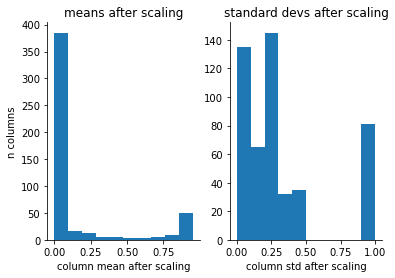

In [12]:
fig,ax= plt.subplots(nrows=1,ncols=2)
ax[0].hist(X_scaled_train.mean())
ax[0].set_title('means after scaling')
ax[0].set_xlabel('column mean after scaling')
ax[0].set_ylabel('n columns')
ax[1].hist(X_scaled_train.std())
ax[1].set_title('standard devs after scaling')
ax[1].set_xlabel('column std after scaling')

sns.despine()
plt.show()

In [13]:
details = utils.variableDetails(targname)
targlabels = details['values']['item']
targlabels.values()

dict_values(['With private health insurance coverage', 'Without private health insurance coverage'])

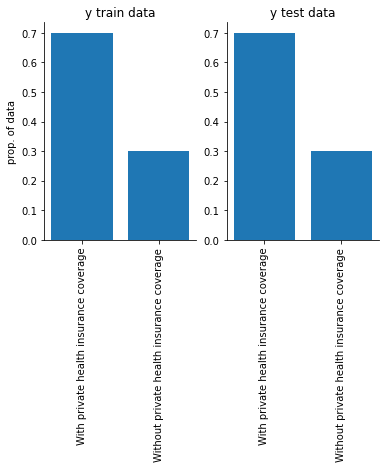

In [14]:
details = utils.variableDetails(targname)
targlabels = details['values']['item']

y_df = pd.DataFrame({'train':y_train,'test':y_test})
fig,ax=plt.subplots(nrows=1,ncols=2)
ax[0].bar(x=[0,1],height=y_df['train'].value_counts(normalize=True))
ax[0].set_title("y train data")
ax[0].set_xticks([0,1])
ax[0].set_xticklabels(labels=targlabels.values(),rotation=90)
ax[0].set_ylabel('prop. of data')
ax[1].bar(x=[0,1],height=y_df['test'].value_counts(normalize=True))
ax[1].set_xticks([0,1])
ax[1].set_xticklabels(labels=targlabels.values(),rotation=90)
ax[1].set_title('y test data')
sns.despine()
plt.show()